# Generate Plots for Negative Controls
### Setup

In [13]:
from __future__ import division

import os
from collections import defaultdict
from cStringIO import StringIO
from json import dumps

from pymongo import MongoClient
from cogent.parse.fasta import MinimalFastaParser
from cogent.core.usage import BaseUsage
from IPython.display import Markdown, display, Image
from pandas import DataFrame

import lib
from outliers import qcrop_facet_grid

In [2]:
%load_ext rpy2.ipython
%R require(ggplot2)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)


array([1], dtype=int32)

In [3]:
try:
    os.mkdir('controls')
except OSError:
    pass

### Utility

In [4]:
def get_omegas(collection):
    omegas = defaultdict(dict)
    for doc in collection.find():
        for taxon, omega in doc['lf']['params']['omega'].items():
            omegas[taxon][doc['_id']] = omega['bin0']
    return omegas

def get_points(gcs, collection):
    omegas = get_omegas(collection)
    points = []
    for taxon in gcs:
        for _id in gcs[taxon]:
            x = gcs[taxon][_id]
            y = omegas[taxon][_id]
            points.append((x, y, taxon, collection.name))
    return points

def print_logs(log,  level='INFO'):
    printmd('##### ' + log.name)
    for d in log.find({'level':level}):
        printmd(dumps(d['message']))
        
def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

In [19]:
%%R

get_ggplot <- function(df)
{   
    ggplot(df, aes(x,y)) +
        geom_point(aes(xcrop, ycrop), alpha=0.2, size=0.5) +
        xlab('GC content') +
        ylab(expression(omega)) +
        stat_quantile(colour="white", size=1.5, alpha=0.5) +
        stat_quantile(colour="black") +
        facet_grid(column ~ row, space="free", scale="free", labeller=label_parsed)
}

### Load Data

In [6]:
client = MongoClient()

In [7]:
cols = ['GNC', 'Y98', 'CNFGTR']
for col in ['data'] + cols:
    print_logs(getattr(client.introns, col + '.log'))

##### data.log

{"input_directory": "/short/xe9/bdk248/data/human_macaque_marmoset_introns/data/introns", "log_level": "DEBUG", "output_collection": "introns.data", "tree_file": "../config/introns.nwk", "db_host": "r3426", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.GNC", "output_collections_file": null, "output_collections": ["introns.GNC"], "db_host": "r3426", "input_collections_file": null, "kwargs": {"model": "GNC", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.7-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.Y98", "output_collections_file": null, "output_collections": ["introns.Y98"], "db_host": "r95", "input_collections_file": null, "kwargs": {"model": "Y98", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.CNFGTR", "output_collections_file": null, "output_collections": ["introns.CNFGTR"], "db_host": "r3426", "input_collections_file": null, "kwargs": {"model": "CNFGTR", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.7-dev"}

In [8]:
gcs = defaultdict(dict)
for i, doc in enumerate(client.introns.data.find()):
    if i % 1000 == 0:
        print 'done', i
    buf = StringIO(doc['aln'].encode('utf-8'))
    aln = MinimalFastaParser(buf)
    for taxon, seq in aln:
        gcs[taxon][doc['_id']] = sum(c in 'GC' for c in seq)/len(seq)

done 0
done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000
done 10000
done 11000
done 12000
done 13000


In [14]:
points = []
for col in cols:
    printmd('#### ' + col)
    new_points = get_points(gcs, getattr(client.introns, col))
    print len(new_points)/3, 'points'
    points += new_points
cropped_points = zip(*qcrop_facet_grid(points))
df = dict(zip(('x', 'y', 'column', 'row', 'xcrop', 'ycrop'), cropped_points))
df = DataFrame(df)

#### GNC

13046.0 points


#### Y98

13046.0 points


#### CNFGTR

13046.0 points


### Generate the Plots

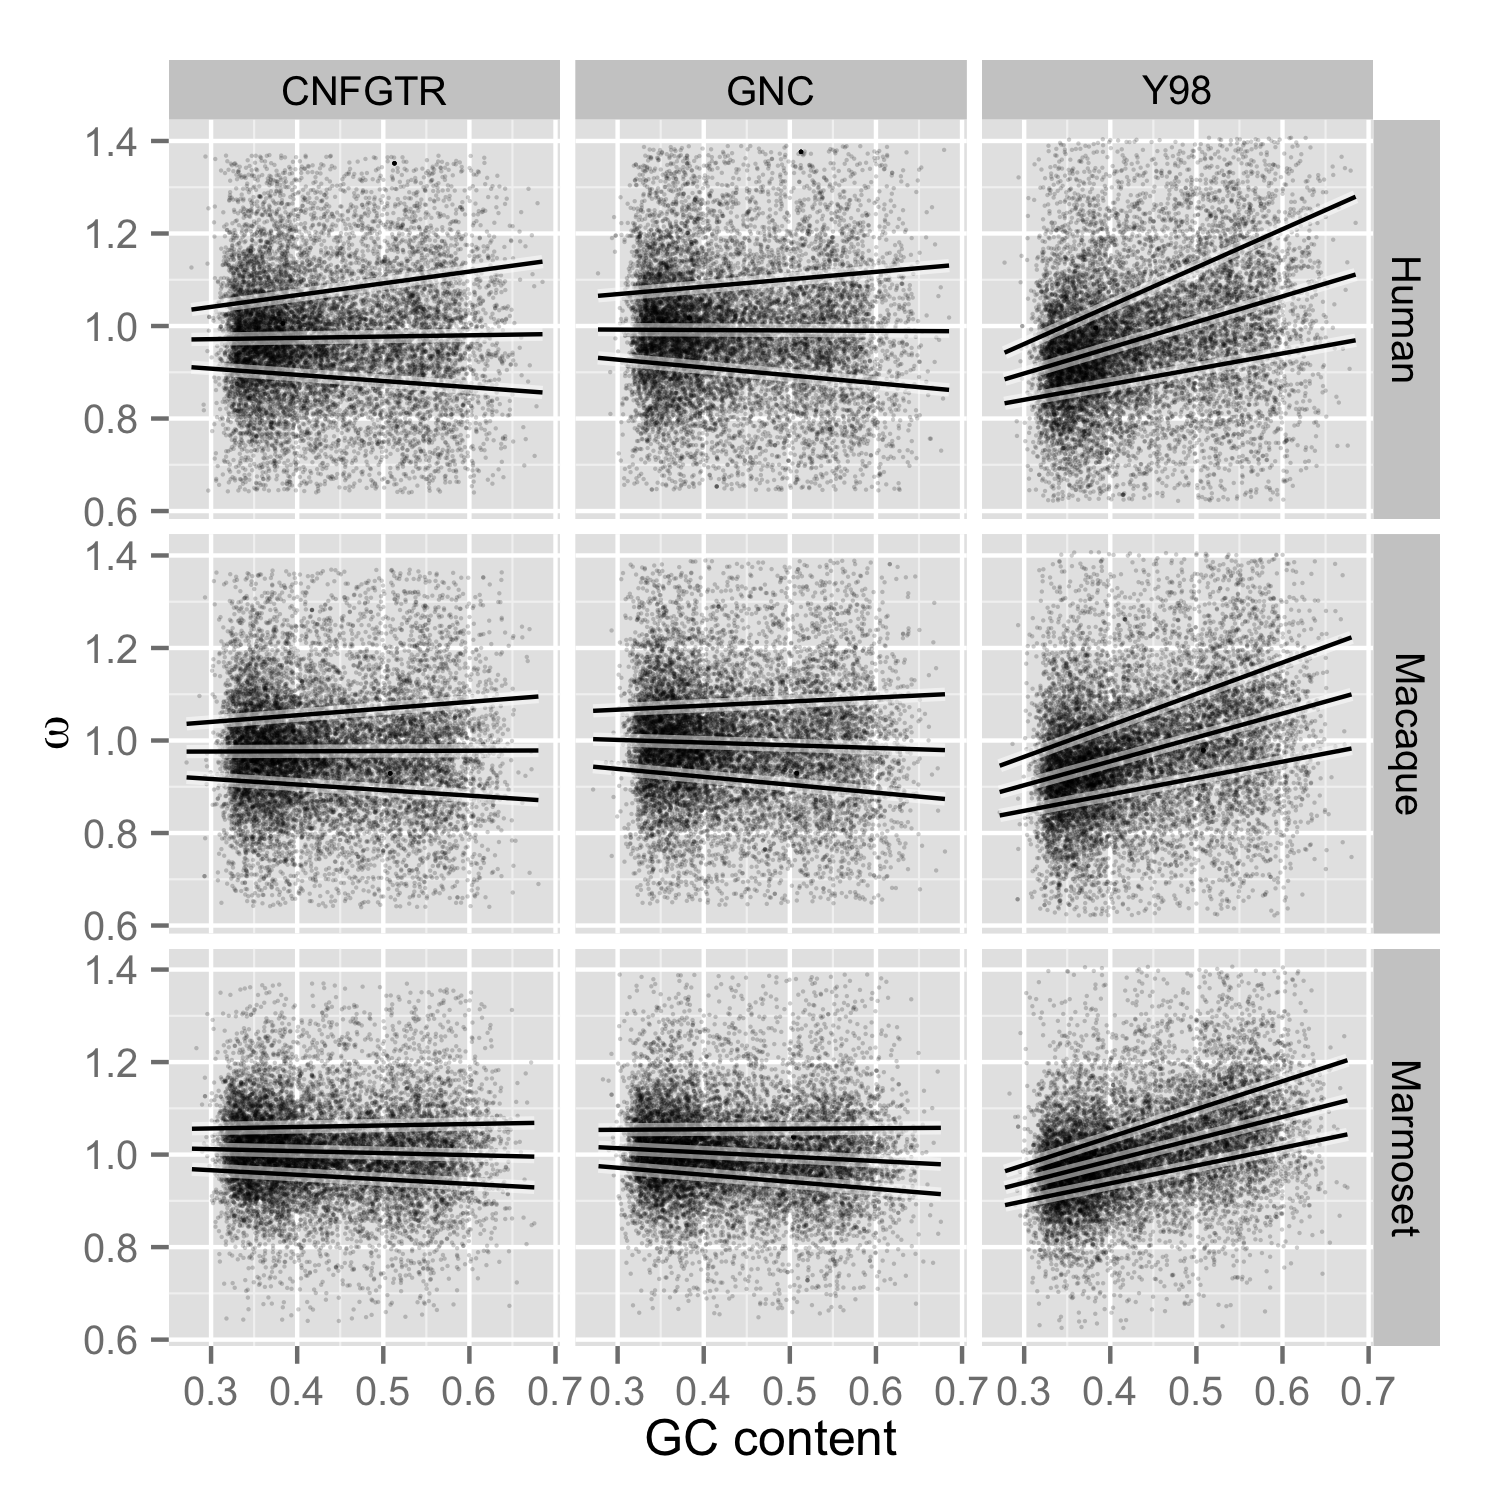

In [20]:
name = os.path.join('controls', 'introns.png')
%R -i df gg <- get_ggplot(df)
%R -i name ggsave(name, gg, width=5, height=5)
display(Image(name))